# 0. IMPORTANT--Specify classifier to be trained and dataset

In [1]:
model_name = 'gbt'  # options include: {'Decision Tree': 'dt', 'Gaussian Naive Bayes':'gnb',\
                           #                  'Logistic Regression': 'lgr', \
                           #                  'Gradient_Boosted_Trees': 'gbt'} 
data_file = '../data/final/simData_oom100.csv'  # ...oom10, ...oom50, ...oom100
save = True

# 1. Imports and Set Up

In [2]:
import sys
sys.path.append('../')
import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)

from impt_functions import *
from visualizations import *
from evaluation import *
import csv
from itertools import zip_longest
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds, \
    TruePositiveRateParity, FalsePositiveRateParity, ErrorRateParity, BoundedGroupLoss
from fairlearn.metrics import *
from raiwidgets import FairnessDashboard
%matplotlib inline

In [3]:
# Instantiate lists for holding unmitigated results
unmitigated, unmitigated_black, unmitigated_white = [], [], []

# 2. Prepare data

In [4]:
data = get_data(data_file)

In [5]:
print(type(data))
print(data)

<class 'pandas.core.frame.DataFrame'>
       score  repay_probability  race  repay_indices
0        570              64.16     1              0
1        828              98.96     1              1
2        837              99.02     1              1
3        502              24.82     1              0
4        534              39.92     1              0
...      ...                ...   ...            ...
99995    740              97.74     1              1
99996    324               2.64     1              0
99997    774              98.44     1              1
99998    738              97.68     1              1
99999    828              98.96     1              1

[100000 rows x 4 columns]


In [6]:
X_train, X_test, y_train, y_test, race_train, race_test, sample_weight_train, sample_weight_test = prep_data(data=data, test_size=0.3, weight_index=1)

In [7]:
# split up X_test by race
X_test_b = []

X_test_w = []

for index in range(len(X_test)):
    if race_test[index] == 0:  # black
        X_test_b.append(X_test[index][0])
    elif race_test[index] == 1:  # white
        X_test_w.append(X_test[index][0])

# given predictions+outcomes, I'll need to do the same 

In [8]:
x = data[['score', 'race']].values
y = data['repay_indices'].values

(array([4.000e+00, 2.150e+02, 7.670e+02, 2.320e+02, 3.130e+02, 6.130e+02,
        6.780e+02, 7.140e+02, 9.240e+02, 7.160e+02, 8.280e+02, 4.740e+02,
        5.880e+02, 1.239e+03, 1.097e+03, 1.350e+03, 6.860e+02, 9.640e+02,
        1.213e+03, 1.598e+03, 1.226e+03, 1.166e+03, 1.416e+03, 1.746e+03,
        1.814e+03, 1.661e+03, 2.358e+03, 1.827e+03, 2.512e+03, 1.973e+03,
        2.322e+03, 2.909e+03, 2.480e+03, 2.814e+03, 2.509e+03, 2.751e+03,
        3.085e+03, 2.798e+03, 3.187e+03, 3.070e+03, 4.127e+03, 3.816e+03,
        3.909e+03, 3.709e+03, 2.889e+03, 3.217e+03, 1.925e+03, 7.890e+02,
        2.451e+03, 3.310e+02]),
 array([300., 311., 322., 333., 344., 355., 366., 377., 388., 399., 410.,
        421., 432., 443., 454., 465., 476., 487., 498., 509., 520., 531.,
        542., 553., 564., 575., 586., 597., 608., 619., 630., 641., 652.,
        663., 674., 685., 696., 707., 718., 729., 740., 751., 762., 773.,
        784., 795., 806., 817., 828., 839., 850.]),
 <BarContainer object of 50 

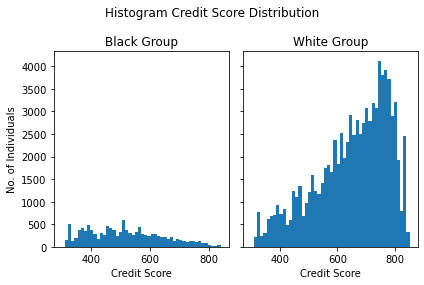

In [9]:
# make histogram of credit scores by race
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

fig.suptitle('Histogram Credit Score Distribution')
plt.xlabel("Credit Score")
#plt.ylabel("No. of Individuals")

black_credit_dist = data['score'].loc[data['race']==0]
white_credit_dist = data['score'].loc[data['race']==1]

n_bins = 50
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(black_credit_dist, bins=n_bins)
axs[0].set_title('Black Group')
axs[0].set_xlabel('Credit Score')
axs[0].set_ylabel('No. of Individuals')
axs[1].set_title('White Group')
axs[1].hist(white_credit_dist, bins=n_bins)

Text(0.5, 1.0, 'White Group')

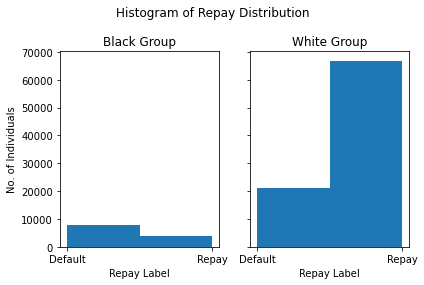

In [10]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

fig.suptitle('Histogram of Repay Distribution')
plt.xlabel('Repay Label')

black_label_dist = data['repay_indices'].loc[data['race']==0]
white_label_dist = data['repay_indices'].loc[data['race']==1]

#print(black_label_dist)
#print(white_label_dist)

# maybe see if the label is an int or a float

# default: 0, repay: 1

n_bins = 2
# We can set the number of bins with the *bins* keyword argument.
#start, end = ax.get_xlim()
stepsize=1
axs[0].xaxis.set_ticks(np.arange(0, 2, stepsize))
axs[0].set_xticklabels(['Default','Repay'])
axs[0].hist(black_label_dist, bins=n_bins)
axs[0].set_title('Black Group')
axs[0].set_ylabel('No. of Individuals')
axs[0].set_xlabel('Repay Label')

axs[1].xaxis.set_ticks(np.arange(0, 2, stepsize))
axs[1].set_xticklabels(['Default','Repay'])
axs[1].hist(white_label_dist, bins=n_bins)
axs[1].set_title('White Group')

# 3. Classifier

In [11]:
print('The classifier trained below is: ', model_name)

The classifier trained below is:  gbt


In [12]:
if model_name == 'dt':
    # Initialize classifier:
    classifier = DecisionTreeClassifier()
elif model_name == 'gnb':
    classifier = GaussianNB()
elif model_name == 'lgr':
    # Reference: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
    classifier = LogisticRegression()
elif model_name == 'svm_linear':
    # Reference: https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
    classifier = svm.SVC(kernel='linear', probability=True)
elif model_name == 'gbt':
    # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    # Note: max_depth default is 3 but tune this parameter for best performance
    classifier = GradientBoostingClassifier(n_estimators=100) 
else:
    print('PROBLEM: input a specified classifier above')

## Train classifier and collect predictions
NOTE: atm sample_weight are all 1s

In [13]:
# Reference: https://www.datacamp.com/community/tutorials/decision-tree-classification-python

# Train the classifier:
model = classifier.fit(X_train,y_train, sample_weight_train)

# Make predictions with the classifier:
y_predict = model.predict(X_test)

# Scores on test set
test_scores = model.predict_proba(X_test)[:, 1]

### Get new scores by race

In [14]:
# think: later on I might want to create a sheet just with the TP and FP scores by race specifically
X_unmit_b, X_unmit_w = get_new_scores(X_test, y_predict, y_test, race_test)

In [15]:
# Code for the above which I turned into a function: get_new_scores
'''
X_unmit_b = []
X_unmit_w = []

for index, label in enumerate(y_predict):
    # first check for TP or FP
    if label == 1 and y_test[index] == 1:  # if it's a TP
        if race_test[index] == 0:  # black
            X_unmit_b.append(X_test[index][0]+75)
        elif race_test[index] == 1:  # white
            X_unmit_w.append(X_test[index][0]+75)
    elif label == 1 and y_test[index] == 0:  # if it's a FP
        if race_test[index] == 0:  # black
            X_unmit_b.append(X_test[index][0]-150)
        elif race_test[index] == 1:  # white
            X_unmit_w.append(X_test[index][0]-150)
    else:  # if it's a TN or FN, no change to credit score
        if race_test[index] == 0:  # black
            X_unmit_b.append(X_test[index][0])
        elif race_test[index] == 1:  # white
            X_unmit_w.append(X_test[index][0])
'''

"\nX_unmit_b = []\nX_unmit_w = []\n\nfor index, label in enumerate(y_predict):\n    # first check for TP or FP\n    if label == 1 and y_test[index] == 1:  # if it's a TP\n        if race_test[index] == 0:  # black\n            X_unmit_b.append(X_test[index][0]+75)\n        elif race_test[index] == 1:  # white\n            X_unmit_w.append(X_test[index][0]+75)\n    elif label == 1 and y_test[index] == 0:  # if it's a FP\n        if race_test[index] == 0:  # black\n            X_unmit_b.append(X_test[index][0]-150)\n        elif race_test[index] == 1:  # white\n            X_unmit_w.append(X_test[index][0]-150)\n    else:  # if it's a TN or FN, no change to credit score\n        if race_test[index] == 0:  # black\n            X_unmit_b.append(X_test[index][0])\n        elif race_test[index] == 1:  # white\n            X_unmit_w.append(X_test[index][0])\n"

### Evaluation of classifier overall

In [16]:
# Metrics
models_dict = {"Unmitigated": (y_predict, test_scores)}
get_metrics_df(models_dict, y_test, race_test)

,Unmitigated
Overall selection rate,0.729433
Demographic parity difference,0.463663
Demographic parity ratio,0.409645
------,
Overall balanced error rate,0.153983
Balanced error rate difference,0.007924
------,
True positive rate difference,0.195238
True negative rate difference,0.179389
False positive rate difference,0.179389


In [17]:
cm = confusion_matrix(y_test, y_predict)
print(cm)
results_dict = classification_report(y_test, y_predict, output_dict=True)
print(classification_report(y_test, y_predict))
# Add accuracy to the results list
unmitigated.append(round(results_dict['accuracy']*100, 2))
f1_micro, f1_weighted, f1_binary = get_f1_scores(y_test, y_predict)
f1_str = str(round(f1_micro*100, 2))+"/"+str(round(f1_weighted*100, 2))+"/"+str(round(f1_binary*100, 2))
# Add f1 scores to results list
unmitigated.append(f1_str)
# Add Selection rate to results list
sr = get_selection_rates(y_test, y_predict, race_test, 0)
unmitigated.append(round(sr*100, 2))
# Add Outcome rates to results list
tnr, tpr, fner, fper = evaluation_outcome_rates(y_test, y_predict, sample_weight_test)
unmitigated.append(round(tnr*100, 2))
unmitigated.append(round(tpr*100, 2))
unmitigated.append(round(fner*100, 2))
unmitigated.append(round(fper*100, 2))

[[ 6646  2085]
 [ 1471 19798]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      8731
           1       0.90      0.93      0.92     21269

    accuracy                           0.88     30000
   macro avg       0.86      0.85      0.85     30000
weighted avg       0.88      0.88      0.88     30000



### Cross-validated metrics

In [18]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x, y, cv=5, scoring='f1_weighted')
print(scores)

[0.88011717 0.87724321 0.88116341 0.88029588 0.87924605]


### Delayed impact calculated

In [19]:
di_black, di_white = calculate_delayed_impact(X_test, y_test, y_predict, race_test)
# Add DI to results list
di_str = str(round(di_black, 2))+"/"+str(round(di_white, 2))
unmitigated.append(di_str)

### Fairness Metric Evaluation of classifier

In [20]:
dp_diff, eod_diff, eoo_dif, fpr_dif, er_dif = print_fairness_metrics(y_test, y_predict, race_test, sample_weight_test)

# Add the fairness metric differences to results list
unmitigated.append(round(dp_diff*100, 2))
unmitigated.append(round(eod_diff*100, 2))
unmitigated.append(round(eoo_dif*100, 2))
unmitigated.append(round(fpr_dif*100, 2))
unmitigated.append(round(er_dif*100, 2))

### Evaluation of classifier by race

In [21]:
results_black, results_white = evaluation_by_race(X_test, y_test, race_test, y_predict, sample_weight_test)
unmitigated_black.extend(results_black)
unmitigated_white.extend(results_white)

### Save results to dictionaries

In [22]:
run_key = 'Unmitigated'
overall_results_dict = add_values_in_dict({}, run_key, unmitigated)
black_results_dict = add_values_in_dict({}, run_key, unmitigated_black)
white_results_dict = add_values_in_dict({}, run_key, unmitigated_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'Unmitigated': [88.15, '88.15/88.02/91.76', 72.94, 76.12, 93.08, 6.92, 23.88, '7.25/38.8', 46.37, 19.52, 19.52, 17.94, 4.39]}
{'Unmitigated': [84.29, '84.29/84.21/76.02', 32.17, 89.1, 74.67, 25.33, 10.9, 7.25]}
{'Unmitigated': [88.68, '88.68/88.46/92.68', 78.54, 71.16, 94.19, 5.81, 28.84, 38.8]}


## Exponentiated Gradient Reduction Alg for Adding Fairness Constraints

In [23]:
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))

### Demographic Parity

In [24]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'DP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


KeyboardInterrupt: 

### Get new scores by race

In [ ]:
### Get new scores by race
X_egDP_b, X_egDP_w = get_new_scores(X_test, y_predict, y_test, race_test)

### Save results to dictionaries

In [ ]:
run_key = 'EG DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Equalized Odds

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'EO', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egEO_b, X_egEO_w = get_new_scores(X_test, y_predict, y_test, race_test)

### Save results to dictionaries

In [ ]:
run_key = 'EG EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### EOO (True Positive Rate Parity)

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'TPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egEOO_b, X_egEOO_w = get_new_scores(X_test, y_predict, y_test, race_test)

### Save results to dictionaries

In [ ]:
run_key = 'EG EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### False Positive Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'FPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egFPRP_b, X_egFPRP_w = get_new_scores(X_test, y_predict, y_test, race_test)

### Save results to dictionaries

In [ ]:
run_key = 'EG FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Error Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'ERP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egERP_b, X_egERP_w = get_new_scores(X_test, y_predict, y_test, race_test)

### Save results to dictionaries

In [ ]:
run_key = 'EG ERP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Bounded Group Loss (issue, need to figure out loss parameter)

In [ ]:
'''
mitigator, results_overall, results_black, results_white= add_constraint(model, 'BGL', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)
run_key = 'EG DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)
'''

## Grid Search Reduction Alg for Adding Fairness Constraints

### Demographic Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'DP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

The next few cells come from: https://github.com/fairlearn/fairlearn/blob/main/notebooks/Binary%20Classification%20with%20the%20UCI%20Credit-card%20Default%20Dataset.ipynb

Note: we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric.

In [ ]:
grid_search_show(mitigator, demographic_parity_difference, y_predict, X_test, y_test, race_test, 'DemParityDifference','GS DPD', models_dict, 0.3)

In [ ]:
models_dict.pop('GS DPD')
models_dict

### Get new scores by race

In [ ]:
X_gsDP_b, X_gsDP_w = get_new_scores(X_test, y_predict, y_test, race_test)

### Save results to dictionaries

In [ ]:
run_key = 'GS DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Equalized Odds Used

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'EO', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
grid_search_show(mitigator, equalized_odds_difference, y_predict, X_test, y_test, race_test, 'EOddsDifference','GS EO', models_dict, 0.3)

In [ ]:
models_dict.pop('GS EO')
models_dict

### Get new scores by race

In [ ]:
X_gsEO_b, X_gsEO_w = get_new_scores(X_test, y_predict, y_test, race_test)

### Save results to dictionaries

In [ ]:
run_key = 'GS EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### EOO (True Positive Rate Parity)

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'TPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
grid_search_show(mitigator, true_positive_rate_difference, y_predict, X_test, y_test, race_test, 'TPRPDifference','GS TPRP', models_dict, 0.3)

In [ ]:
models_dict.pop('GS TPRP')
models_dict

### Get new scores by race

In [ ]:
X_gsEOO_b, X_gsEOO_w = get_new_scores(X_test, y_predict, y_test, race_test)

### Save results to dictionaries

In [ ]:
run_key = 'GS EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### False Positive Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'FPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
# NOTE: the below models are the same for DT classifier!!

In [ ]:
grid_search_show(mitigator, false_positive_rate_difference, y_predict, X_test, y_test, race_test, 'FPRPDifference','GS FPRP', models_dict, 0.4)

In [ ]:
models_dict.pop('GS FPRP')
models_dict

### Get scores by race

In [ ]:
X_gsFPRP_b, X_gsFPRP_w = get_new_scores(X_test, y_predict, y_test, race_test)

### Save results to dictionaries

In [ ]:
run_key = 'GS FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Error Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'ERP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
# Fairlearn doesnt have an erp difference metric for the below
#grid_search_show(gs_erp, error_difference, y_predict, X_test, y_test, race_test, 'ERDifference','GS ERP', models_dict, 0.3)
#models_dict.pop('GS FPRP')
#models_dict

### Get scores by race

In [ ]:
X_gsERP_b, X_gsERP_w = get_new_scores(X_test, y_predict, y_test, race_test)

### Save results to dictionaries

In [ ]:
run_key = 'GS ERP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Bounded Group Loss (issue, need to figure out loss parameter)

In [ ]:
'''
mitigator, results_overall, results_black, results_white= add_constraint(model, 'BGL', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)
run_key = 'GS EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)
'''

In [ ]:
# We can examine the values of lambda_i chosen for us:
#lambda_vecs = gs_dp.lambda_vecs_
#print(lambda_vecs[0])

# 4. Save results to csv files

In [ ]:
# To use below!!
if save == True:
    overall_fieldnames = ['Run', 'Acc', 'F1micro/F1w/F1bsr', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DIB/DIW', 'DP Diff', 'EO Diff', 'TPR Diff', 'FPR Diff', 'ER Diff']
    byrace_fieldnames = ['Run', 'Acc', 'F1micro/F1w/F1bsr', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DI']
    save_dict_2_csv(overall_results_dict, overall_fieldnames, model_name+'_overall_results.csv')
    save_dict_2_csv(black_results_dict, byrace_fieldnames, model_name+'_black_results.csv')
    save_dict_2_csv(white_results_dict, byrace_fieldnames, model_name+'_white_results.csv')

In [ ]:
if save == True:
    # Save overall score results
    scores_fieldnames = ['testB', 'testW', 'unmitB', 'unmitW', 'egdpB', 'egdpW', 'egeoB', 'egeoW', 'egeooB', 'egeooW', 'egfprpB', 'egfprpW', 'egerpB', 'egerpW', 'gsdpB', 'gsdpW', 'gseoB', 'gseoW', 'gseooB', 'gseooW', 'gsfprpB', 'gsfprpW', 'gserpB', 'gserpW']
    data = [X_test_b, X_test_w, X_unmit_b, X_unmit_w, X_egDP_b, X_egDP_w, X_egEO_b, X_egEO_w, X_egEOO_b, X_egEOO_w, X_egFPRP_b, X_egFPRP_w, X_egERP_b, X_egERP_w, X_gsDP_b, X_gsDP_w, X_gsEO_b, X_gsEO_w, X_gsEOO_b, X_gsEOO_w, X_gsFPRP_b, X_gsFPRP_w, X_gsERP_b, X_gsERP_w ]
    columns_data = zip_longest(*data)

    with open(model_name+'_overall_scores.csv',mode='w') as f:
        writer = csv.writer(f)
        writer.writerow(scores_fieldnames)
        writer.writerows(columns_data)
        f.close()
    
    # Save black score results
    scores_black_fieldnames = ['testB', 'unmitB', 'egdpB','egeoB','egeooB','egfprpB', 'egerpB','gsdpB','gseoB','gseooB', 'gsfprpB', 'gserpB']
    data_black = [X_test_b, X_unmit_b, X_egDP_b, X_egEO_b, X_egEOO_b, X_egFPRP_b, X_egERP_b, X_gsDP_b, X_gsEO_b, X_gsEOO_b, X_gsFPRP_b, X_gsERP_b]
    columns_data_black = zip_longest(*data_black)
    with open(model_name+'_black_scores.csv',mode='w') as b:
        writer = csv.writer(b)
        writer.writerow(scores_black_fieldnames)
        writer.writerows(columns_data_black)
        b.close()
        
   # Save white score results
    scores_white_fieldnames = ['testW','unmitW','egdpW','egeoW','egeooW', 'egfprpW', 'egerpW','gsdpW','gseoW', 'gseooW','gsfprpW','gserpW']
    data_white = [X_test_w, X_unmit_w, X_egDP_w, X_egEO_w, X_egEOO_w, X_egFPRP_w, X_egERP_w, X_gsDP_w, X_gsEO_w,X_gsEOO_w, X_gsFPRP_w, X_gsERP_w]
    columns_data_white = zip_longest(*data_white)
    with open(model_name+'_white_scores.csv',mode='w') as w:
        writer = csv.writer(w)
        writer.writerow(scores_white_fieldnames)
        writer.writerows(columns_data_white)
        w.close()
    
    # Save exponentiated gradient results
    scores_eg_fieldnames = ['testB', 'testW', 'unmitB', 'unmitW', 'egdpB', 'egdpW', 'egeoB', 'egeoW', 'egeooB', 'egeooW', 'egfprpB', 'egfprpW', 'egerpB', 'egerpW']
    data_eg = [X_test_b, X_test_w, X_unmit_b, X_unmit_w, X_egDP_b, X_egDP_w, X_egEO_b, X_egEO_w, X_egEOO_b, X_egEOO_w, X_egFPRP_b, X_egFPRP_w, X_egERP_b, X_egERP_w]
    columns_data_eg = zip_longest(*data_eg)
    with open(model_name+'_eg_scores.csv', mode='w') as e:
        writer = csv.writer(e)
        writer.writerow(scores_eg_fieldnames)
        writer.writerows(columns_data_eg)
        e.close()
    
    # Save grid search results
    scores_gs_fieldnames = ['testB', 'testW', 'unmitB', 'unmitW', 'gsdpB', 'gsdpW', 'gseoB', 'gseoW', 'gseooB', 'gseooW', 'gsfprpB', 'gsfprpW', 'gserpB', 'gserpW']
    data_gs = [X_test_b, X_test_w, X_unmit_b, X_unmit_w,  X_gsDP_b, X_gsDP_w, X_gsEO_b, X_gsEO_w, X_gsEOO_b, X_gsEOO_w, X_gsFPRP_b, X_gsFPRP_w, X_gsERP_b, X_gsERP_w]
    columns_data_gs = zip_longest(*data_gs)
    with open(model_name+'_gs_scores.csv', mode='w') as g:
        writer = csv.writer(g)
        writer.writerow(scores_gs_fieldnames)
        writer.writerows(columns_data_gs)
        g.close()
    